<div style="background-color: #ADD8E6; padding: 20px; border-radius: 10px; box-shadow: 2px 2px 10px grey;">

#### Project Introduction: Sentiment Analysis for the Film Junky Union Community

**Project Overview:**  
As part of the data science team at the Film Junky Union, a community for aficionados of classic cinema, I developed a sentiment analysis model to categorize movie reviews. Utilizing a labeled IMDB dataset, the objective was to train a model capable of distinguishing between positive and negative reviews with a high degree of accuracy, aiming for an F1 score of at least 0.85.

**Project Objectives:**

- **Data Preparation:**  
  Load and preprocess the IMDB reviews dataset for vectorization and modeling.

- **Exploratory Data Analysis (EDA):**  
  Conduct EDA to understand data distribution and class imbalance. Devise strategies to address any imbalance for model training.

- **Model Training:**  
  Implement and compare at least three different machine learning models on the training dataset, fine-tuning hyperparameters for optimal performance.

- **Model Evaluation:**  
  Test the models on a separate test dataset and analyze their performance using the F1 score as the key metric.

- **Practical Application:**  
  Compose original reviews and classify them using the trained models to assess real-world applicability.

- **Findings and Conclusions:**  
  Present insights and conclusions based on the models' performance, both on the given dataset and the original reviews.

**Data Description:**

- The dataset (`imdb_reviews.tsv`) contains text reviews and corresponding sentiment labels ('0' for negative, '1' for positive) along with train/test partitions.

**Methodological Notes:**

- The project leverages logistic regression and gradient boosting classifiers, with an openness to exploring additional methods.
- Advanced techniques like BERT embeddings are considered for enhancing model performance, with computational constraints taken into account.

**Conclusion:**

This project underscores my proficiency in NLP and sentiment analysis, showcasing my ability to derive meaningful insights from textual data and contribute to enhancing user experience within the Film Junky Union's digital platforms.

</div>


## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

<div style="background-color:#ADD8E6; padding: 10px; border-radius: 5px;">
    <h3>Data Loading</h3>
    <p>Let's begin by loading the IMDB reviews dataset and examining its basic structure.</p>
</div>

In [4]:
# Load the dataset
file_path = '/datasets/imdb_reviews.tsv'
df_reviews = pd.read_csv(file_path, sep='\t', dtype={'votes': 'Int64'})

# Display basic info about the dataset
print("### Basic Information about the Dataset:\n")
df_reviews.info()

### Basic Information about the Dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx             

<div style="background-color:#ADD8E6; padding: 10px; border-radius: 5px;">
    <h3>Dataset Overview</h3>
    <p>Below are the first few entries from the dataset, giving us a snapshot of the available information for each movie review.</p>
</div>


In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


<div style="background-color:#ADD8E6; padding: 10px; border-radius: 5px;">
    <h3>Data Validation</h3>
    <p>To ensure the quality of our dataset, let's check for missing values in our columns.</p>
</div>

In [6]:
# Check for missing values in all columns
missing_values = df_reviews.isnull().sum()

print("Missing values for each column:\n")
print('-'*40)
for column, missing_count in missing_values.items():
    # If there are missing values in the column, highlight the output
    if missing_count > 0:
        print(f"\033[94m{column}: {missing_count}\033[0m")
    else:
        print(f"{column}: {missing_count}")
print('-'*40, '\n')

Missing values for each column:

----------------------------------------
tconst: 0
title_type: 0
primary_title: 0
original_title: 0
start_year: 0
end_year: 0
runtime_minutes: 0
is_adult: 0
genres: 0
average_rating: 2
votes: 2
review: 0
rating: 0
sp: 0
pos: 0
ds_part: 0
idx: 0
---------------------------------------- 



<div style="background-color:#ADD8E6; padding: 10px; border-radius: 5px;">
    <h3>Handling Missing Values</h3>
    <p>
    Upon inspection, we discovered missing values in the <i>average_rating</i> and <i>votes</i> columns. However, as our primary goal is to develop a sentiment analyzer based on movie reviews, these particular columns aren't essential to our analysis. Hence, we've opted not to address these missing values for the current task.
    </p>
</div>

<div style="background-color:#ADD8E6; padding: 10px; border-radius: 5px;">
    <h3>Data Distribution</h3>
    <p>Understanding how our data is distributed is crucial. Let's observe the distribution of training vs. testing samples, as well as the distribution across different review types.</p>
</div>

In [7]:
# Check the distribution of training and testing samples
print("Distribution of training and testing samples:\n")
print('-'*40)
print(df_reviews['ds_part'].value_counts())
print('-'*40, '\n')

# Examine the distribution of review types (movies, short films, etc.)
print("Distribution of review types:\n")
print('-'*40)
print(df_reviews['title_type'].value_counts())
print('-'*40)

Distribution of training and testing samples:

----------------------------------------
train    23796
test     23535
Name: ds_part, dtype: int64
---------------------------------------- 

Distribution of review types:

----------------------------------------
movie           36861
tvMovie          2892
video            2742
tvSeries         2246
short             887
tvMiniSeries      713
tvEpisode         635
tvSpecial         183
videoGame         154
tvShort            18
Name: title_type, dtype: int64
----------------------------------------


<div style="background-color:#ADD8E6; padding: 10px; border-radius: 5px;">
    <h3>Duplicates Assessment</h3>
    <p>
    To ensure the integrity and uniqueness of our dataset, we assessed it for any duplicate entries. Duplicates can potentially skew the training and evaluation of our models, so it's imperative to identify and handle them appropriately.
    </p>
    </div>

In [8]:
# Check for duplicates in the dataframe
duplicate_rows = df_reviews[df_reviews.duplicated()]
print("Number of duplicate rows:", len(duplicate_rows))

if len(duplicate_rows) > 0:
    print('-'*40)
    print("Displaying first few duplicate rows:\n")
    print(duplicate_rows.head())
    print('-'*40)
else:
    print("No duplicates found.")

Number of duplicate rows: 0
No duplicates found.


<div class="alert alert-success">
<b>Reviewer's comment</b>

Good, the data was loaded and inspected!

</div>

## EDA

Let's check the number of movies and reviews over years.

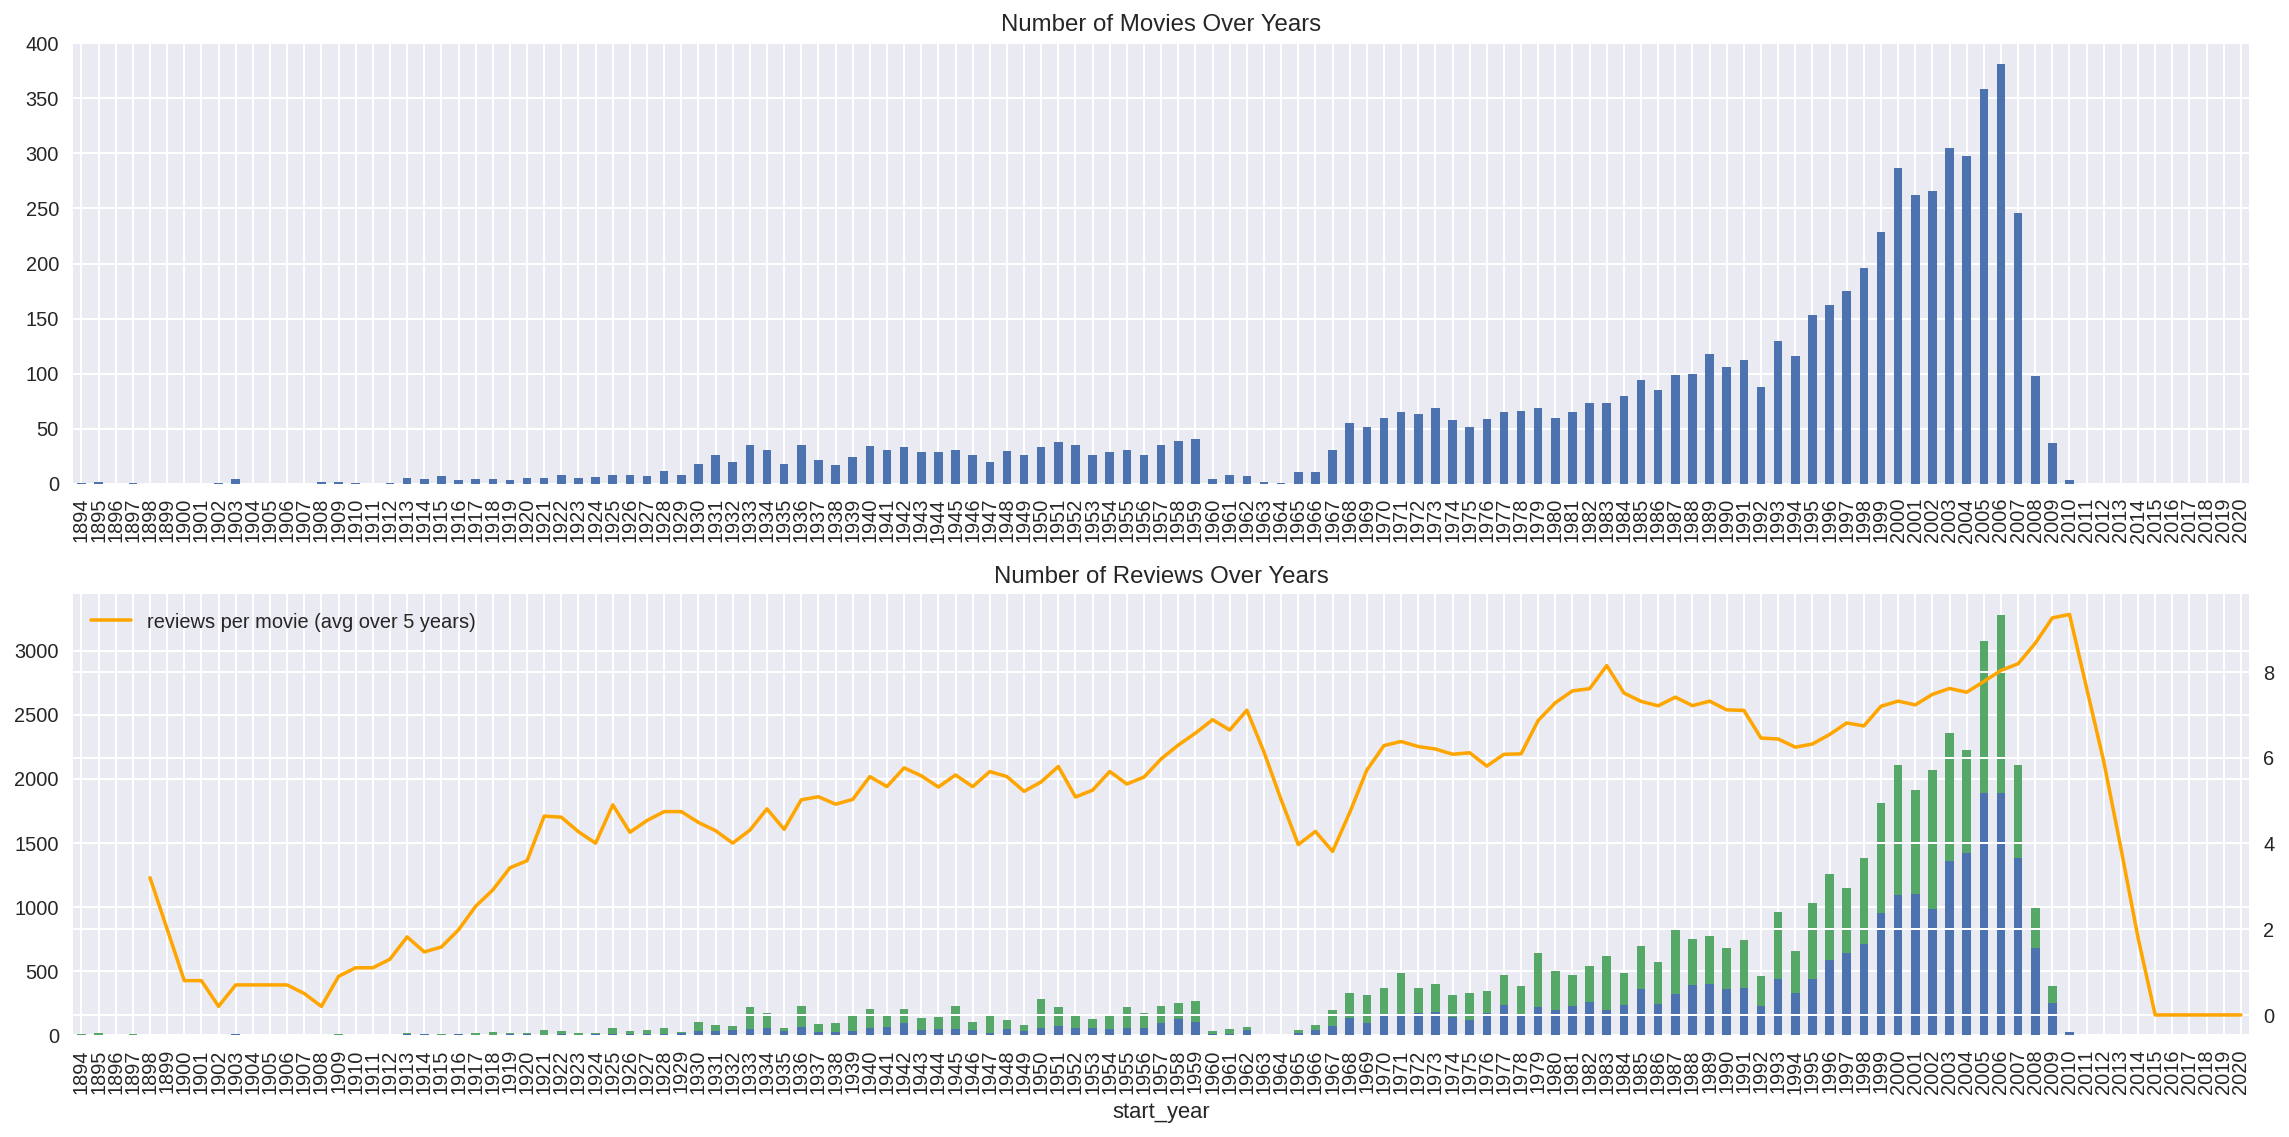

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

In [10]:
# Extracting key data points
most_movies_year = dft1.idxmax()
most_reviews_year = dft2.idxmax()

avg_reviews = (dft2/dft1).fillna(0)
avg_reviews_peak_year = avg_reviews.rolling(5).mean().idxmax()

print(f"The year with the most movies released was {most_movies_year}, with a total of {dft1[most_movies_year]} movies.")
print(f"The year with the most reviews was {most_reviews_year}, with {dft2[most_reviews_year]} reviews.")
print(f"The highest average number of reviews per movie, when considering a 5-year rolling average, peaked in {avg_reviews_peak_year}.")

The year with the most movies released was 2006, with a total of 381.0 movies.
The year with the most reviews was 2006, with 3275.0 reviews.
The highest average number of reviews per movie, when considering a 5-year rolling average, peaked in 2010.


Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

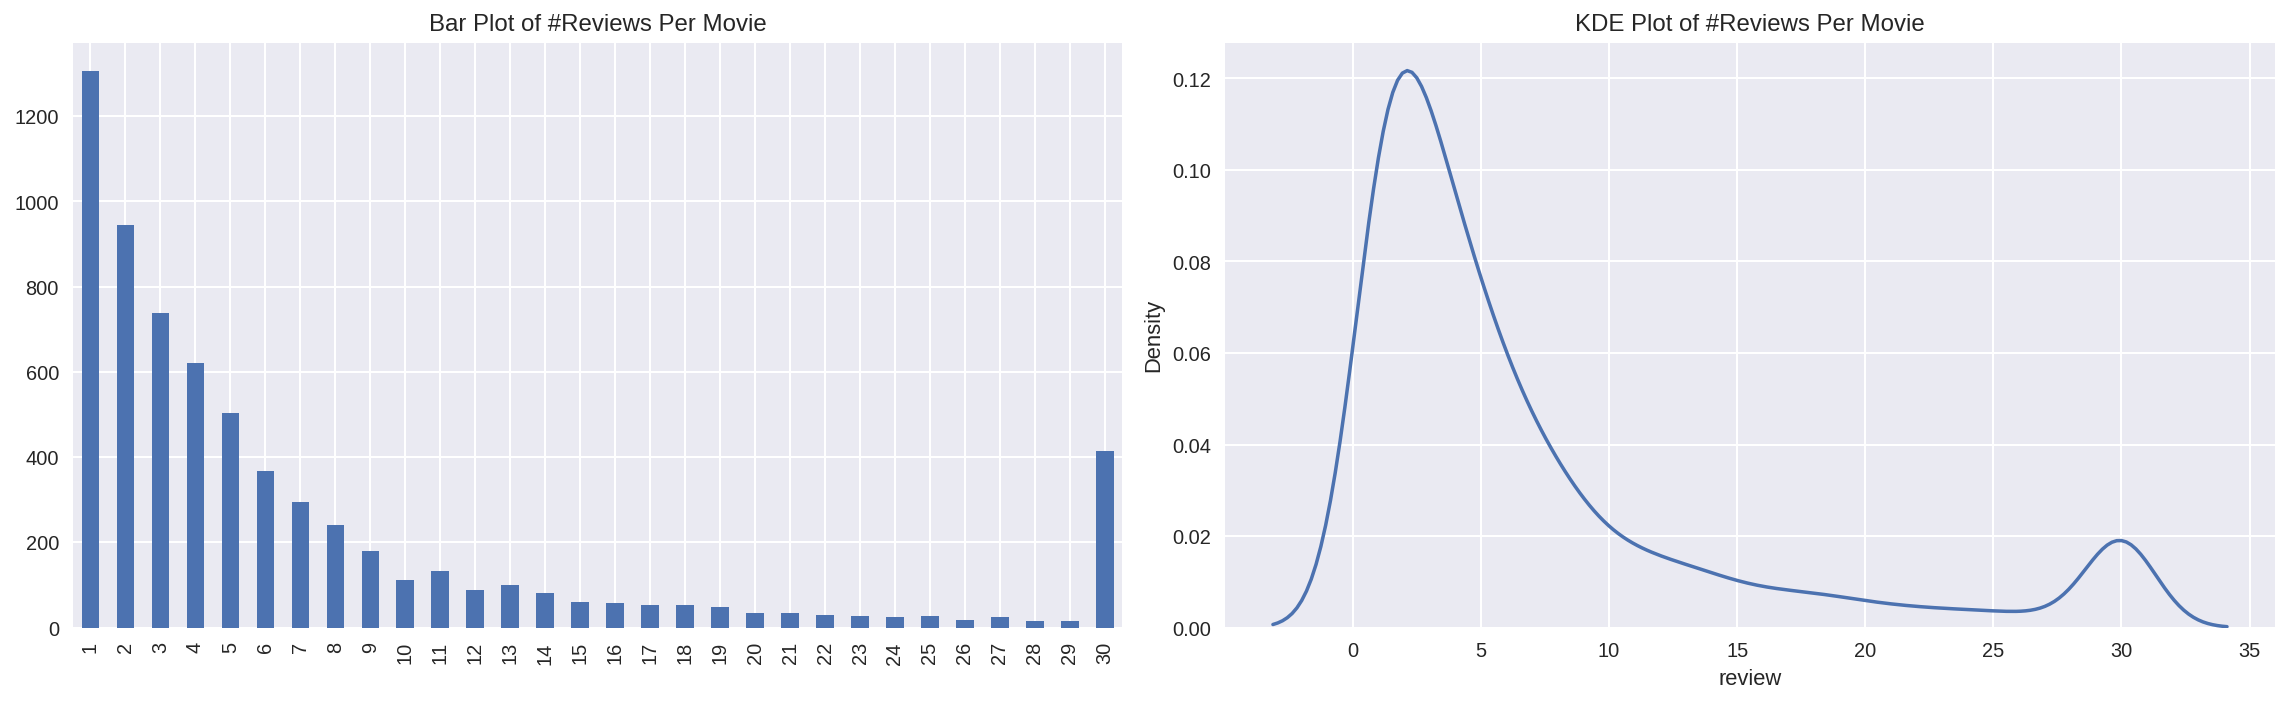

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

<div style="background-color:#ADD8E6; padding: 20px; border-radius: 5px;">

## Analysis of Reviews Per Movie

**Key Metrics:**
<div style="margin-left: 20px;">
    <ul>
        <li><b>Average Number of Reviews:</b> 7.12</li>
        <li><b>Median Number of Reviews:</b> 4.0</li>
        <li><b>Mode of Reviews:</b> 1</li>
        <li><b>Maximum Number of Reviews:</b> 30</li>
        <li><b>Minimum Number of Reviews:</b> 1</li>
    </ul>
</div>

**Insights from Visuals:**
<div style="margin-left: 20px;">
    <p>The <b>bar plot</b> indicates a dominant peak at 1 review, followed by a gradual decline leading up to 30 reviews.</p>
    <p>The <b>KDE plot</b> confirms this peak at a single review, emphasizing that most movies typically receive just one review. Notably, there's a spike at 30, suggesting that certain films deeply resonate with the audience or are otherwise notable, prompting a higher volume of feedback.</p>
</div>

**Deeper Interpretations and Considerations:**
<div style="margin-left: 20px;">
    <p>The predominant peak at a single review across both visuals underscores that a vast number of films receive only minimal feedback.</p>
    <p>The KDE plot's discernible spike at 30 reviews could hint at a niche subset of movies that either deeply resonate with the audience or provoke substantial commentary, motivating viewers to voice their opinions.</p>
    <p>One might ponder the reasons behind the majority of movies fetching just one review. Could it be attributed to restricted viewership, or might it reflect the characteristics of the review collection platform?</p>
    <p>Films accruing as many as 30 reviews could potentially be blockbusters, particularly divisive, or benefit from significant promotional campaigns.</p>
</div>

<p style="font-style:italic;">By delving into these aspects, we can strive to understand the nuanced relationship between movie characteristics and audience engagement in the form of reviews.</p>

</div>


In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

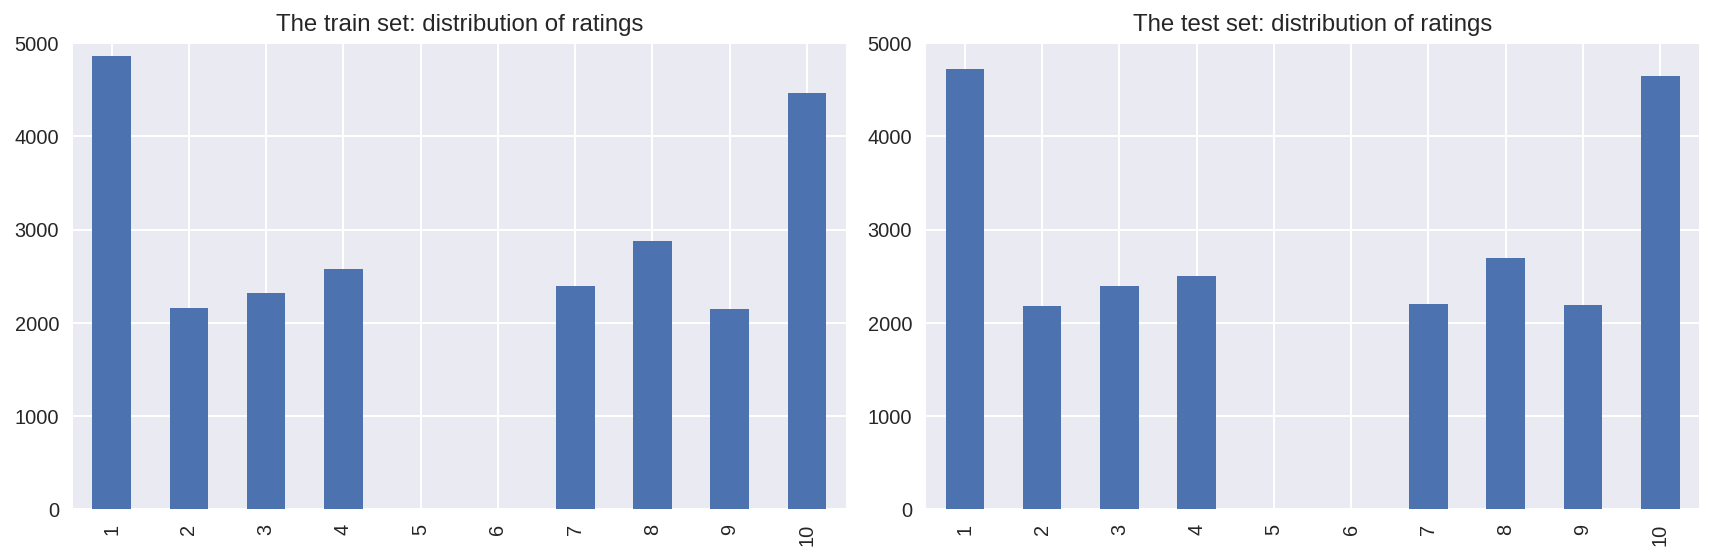

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

<div style="background-color:#ADD8E6; padding: 20px; border-radius: 5px;">

## Sentiment Distribution in Reviews

**Sentiment Counts:**
<div style="margin-left: 20px;">
    <ul>
        <li><b>Negative Reviews (labeled as 0):</b> 23,715</li>
        <li><b>Positive Reviews (labeled as 1):</b> 23,616</li>
    </ul>
</div>

**Insights from the Data:**
<div style="margin-left: 20px;">
    <p>Reviews labeled as <b>0</b> typically indicate negative sentiment.</p>
    <p>Conversely, reviews labeled as <b>1</b> usually suggest positive sentiment.</p>
    <p>The distribution between the two categories is almost balanced, with only a slight prevalence of the <b>0</b> category.</p>
</div>

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


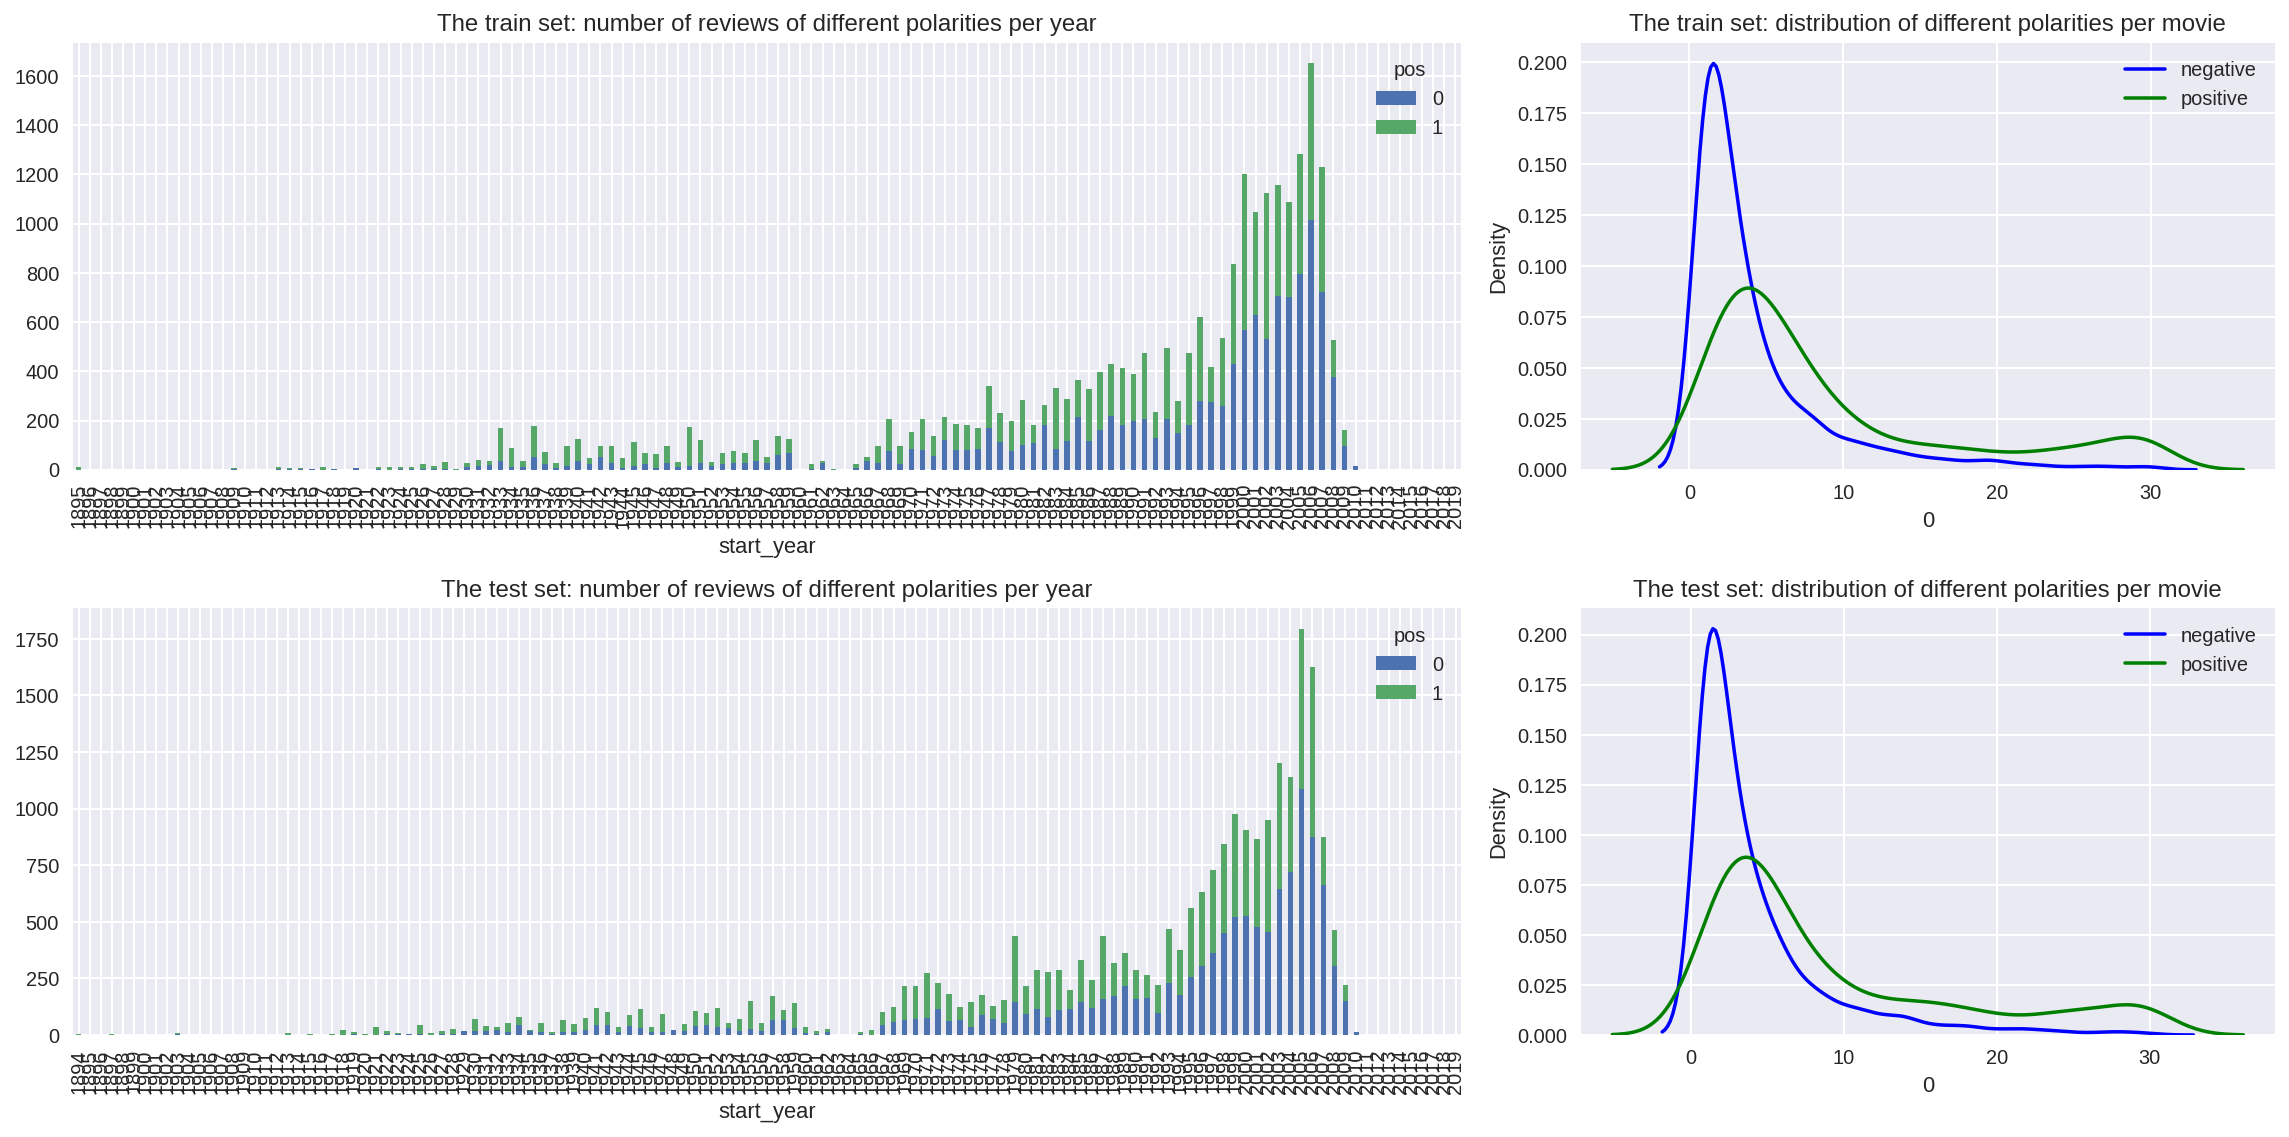

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the data and made some interesting observations!

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [16]:
import string
import re

In [17]:

def normalize_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Normalization looks good!

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [19]:
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


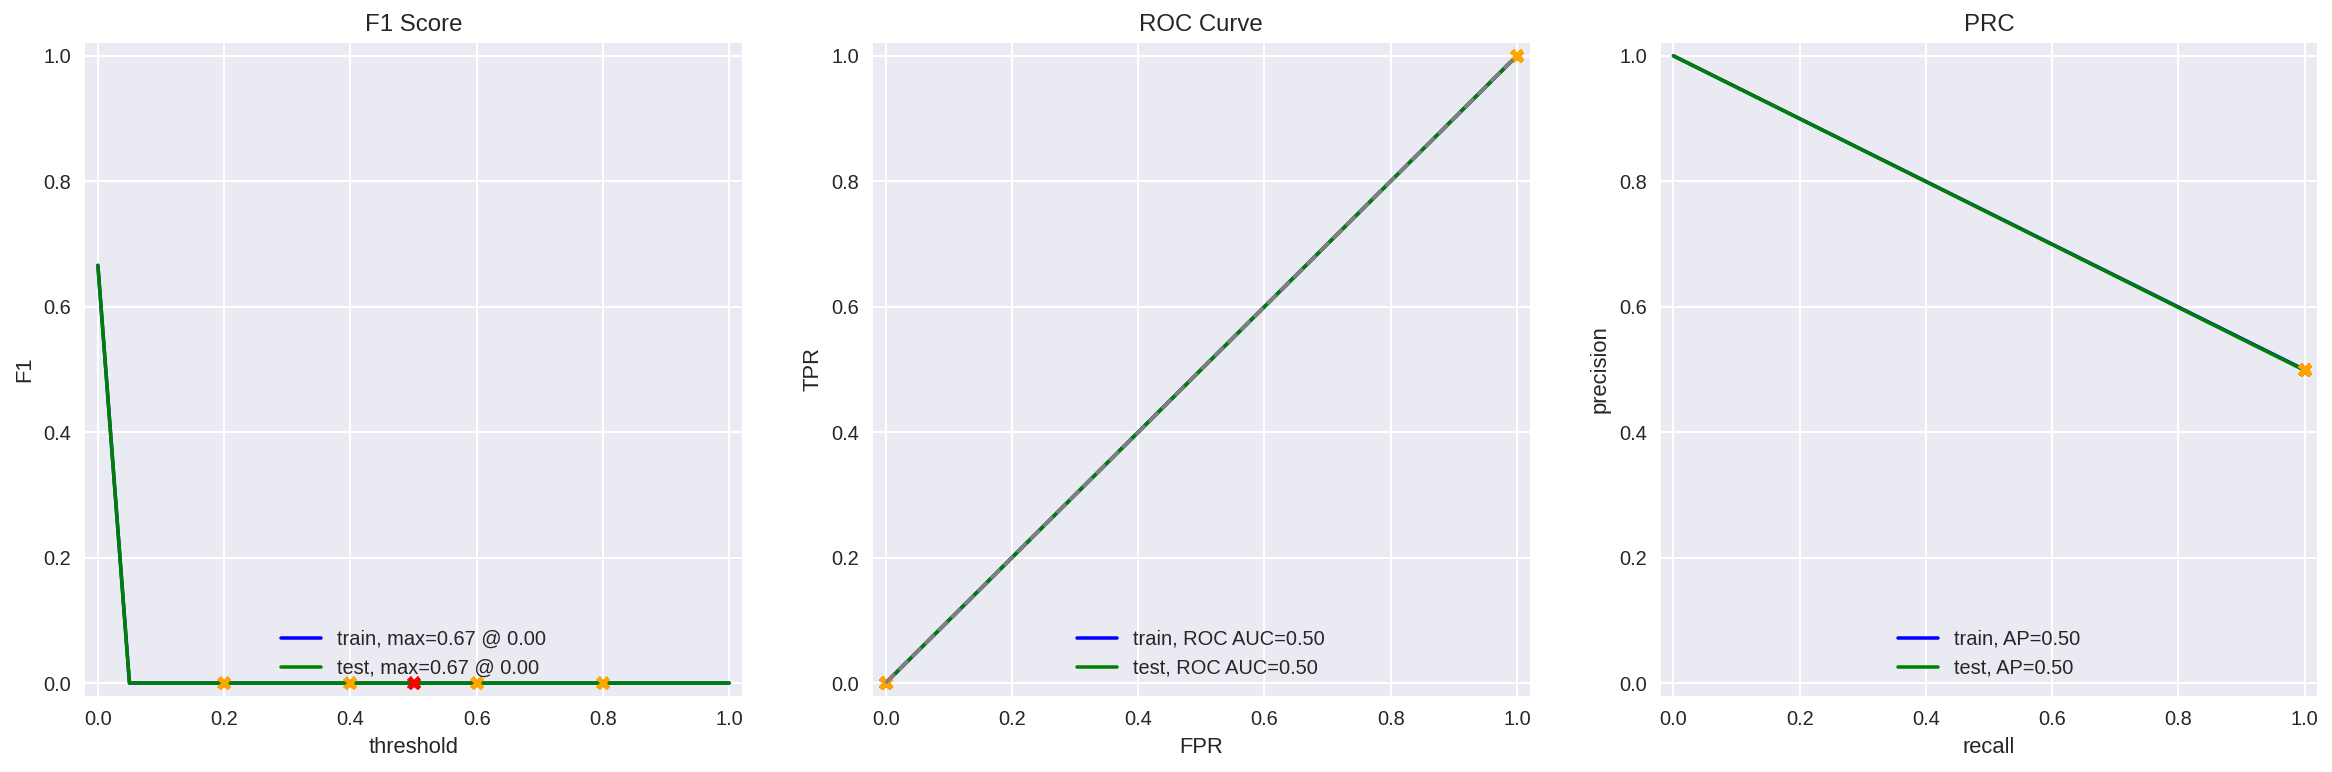

In [20]:
# Create the dummy classifier
clf_constant = DummyClassifier(strategy='most_frequent')
clf_constant.fit(df_reviews_train['review_norm'], train_target)

# Evaluate the classifier using the evaluation function you defined earlier
evaluate_model(clf_constant, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, there is a simple constant baseline

</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [21]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [22]:
# First, ensure you have the NLTK stopwords downloaded
nltk.download('stopwords')

# Initialize the TF-IDF Vectorizer with stopwords
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

# Transform train and test reviews to tf-idf vectors
train_features_1 = vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = vectorizer.transform(df_reviews_test['review_norm'])


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
model_1 = LogisticRegression(max_iter=1000)  
model_1.fit(train_features_1, train_target)


LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


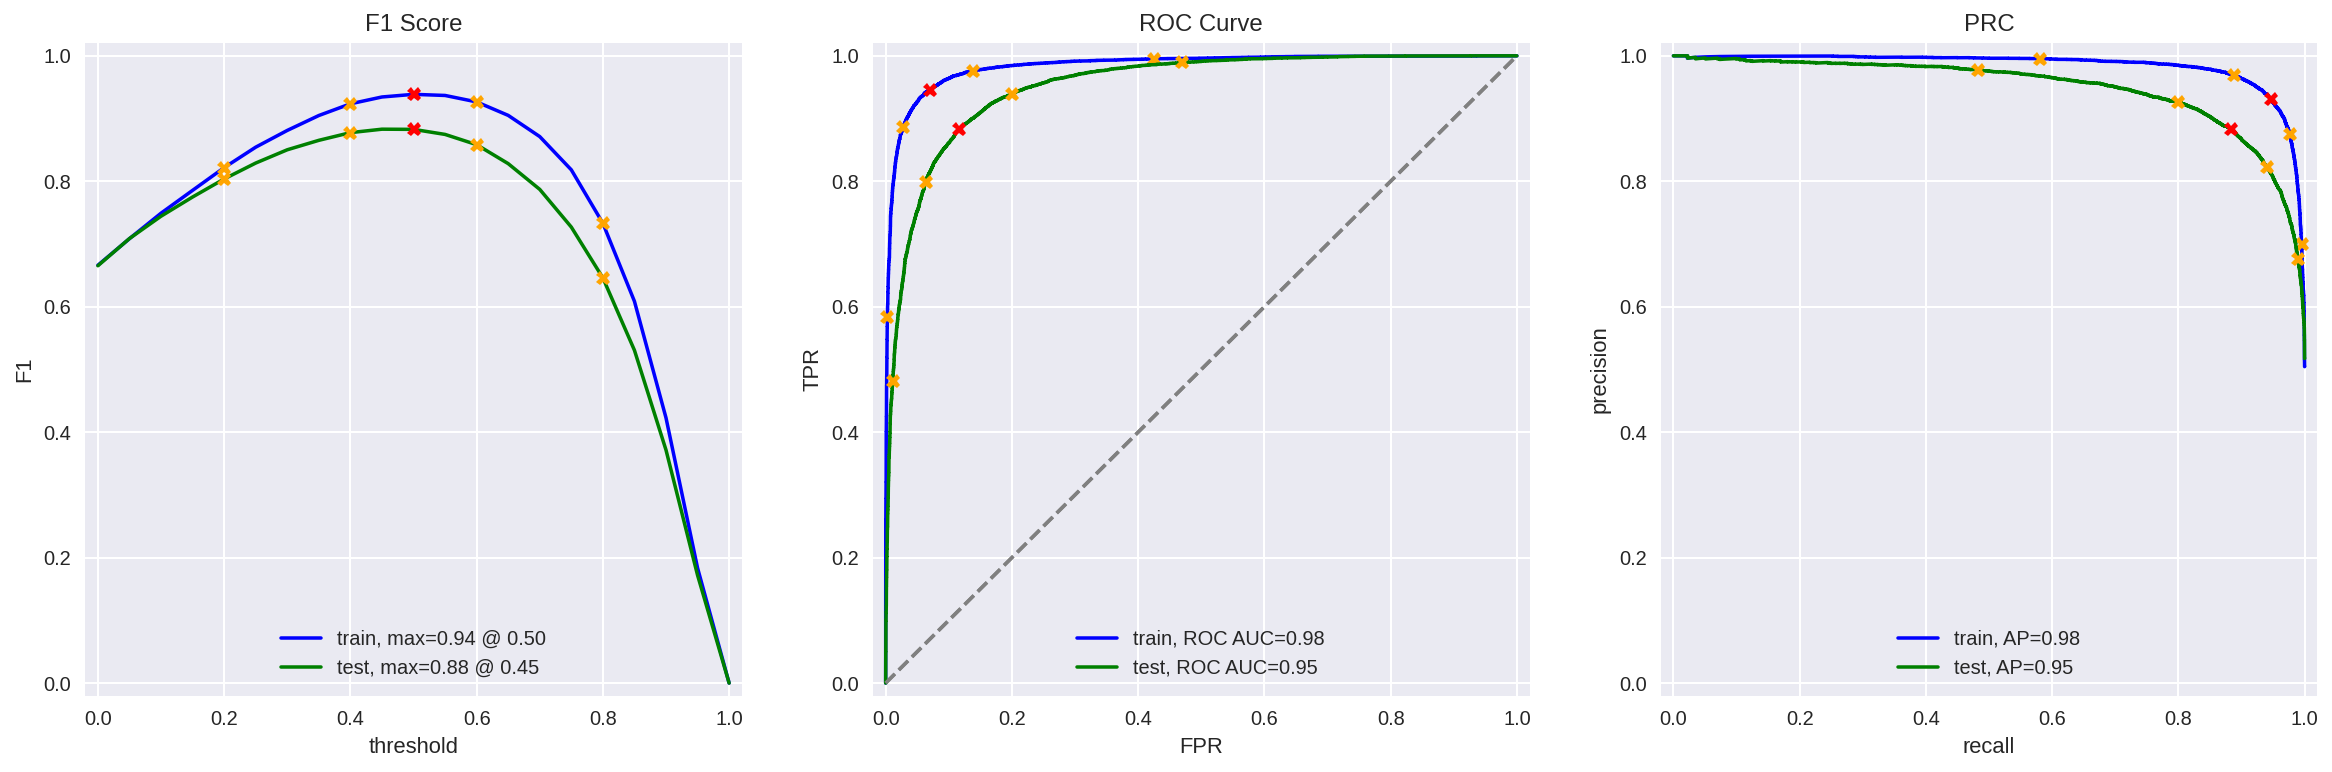

In [24]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [25]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's nice that you tried lemmatization!

</div>

In [27]:
# Preprocess the reviews in training and testing datasets
train_X_preprocessed = df_reviews_train['review_norm'].apply(text_preprocessing_3)
test_X_preprocessed = df_reviews_test['review_norm'].apply(text_preprocessing_3)

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.94  0.93
ROC AUC    0.94  0.93


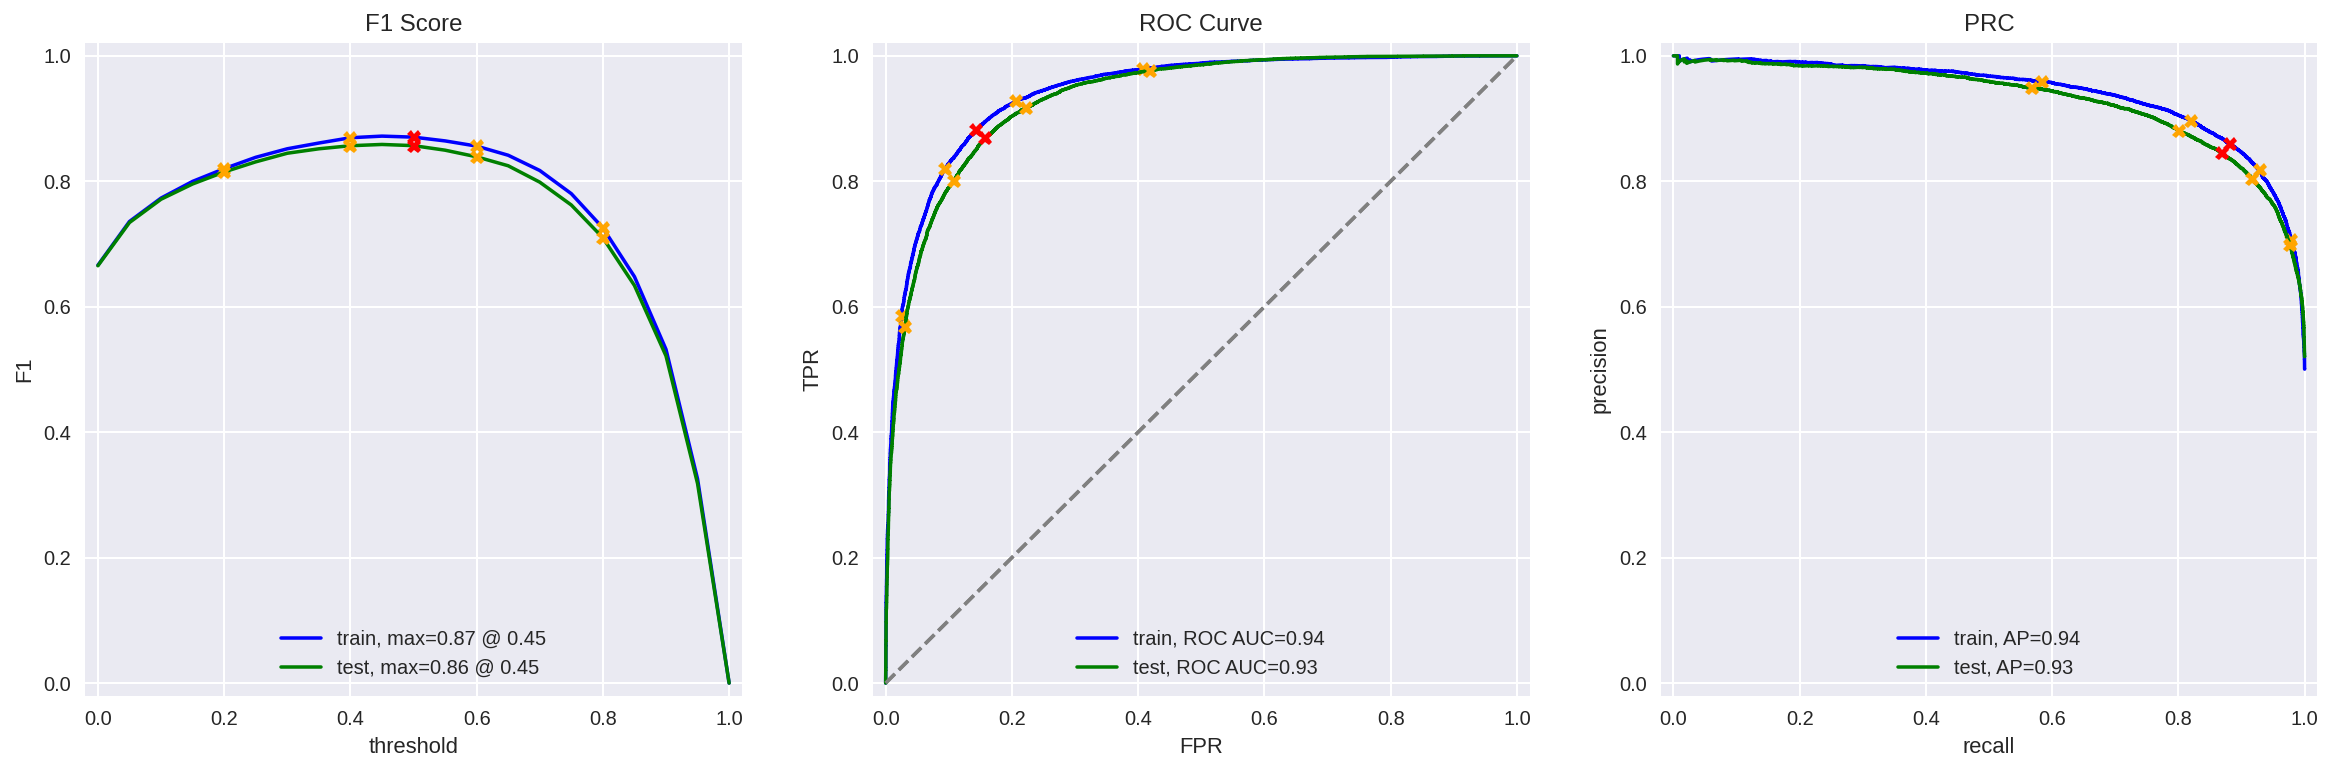

In [28]:
# Get the set of stopwords from spaCy
stop_words = nlp.Defaults.stop_words

# Create a TF-IDF vectorizer instance
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=1000)

# Fit the vectorizer to the training data and transform both training and test data
train_X_tfidf = tfidf_vectorizer.fit_transform(train_X_preprocessed)
test_X_tfidf = tfidf_vectorizer.transform(test_X_preprocessed)

# Create and train a logistic regression model
lr_model = LogisticRegression(random_state=12345, solver='saga', n_jobs=-1)
lr_model.fit(train_X_tfidf, train_target)

# Evaluate model
evaluate_model(lr_model, train_X_tfidf, train_target, test_X_tfidf, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [29]:
from lightgbm import LGBMClassifier

          train  test
Accuracy   0.90  0.84
F1         0.90  0.84
APS        0.96  0.92
ROC AUC    0.96  0.92


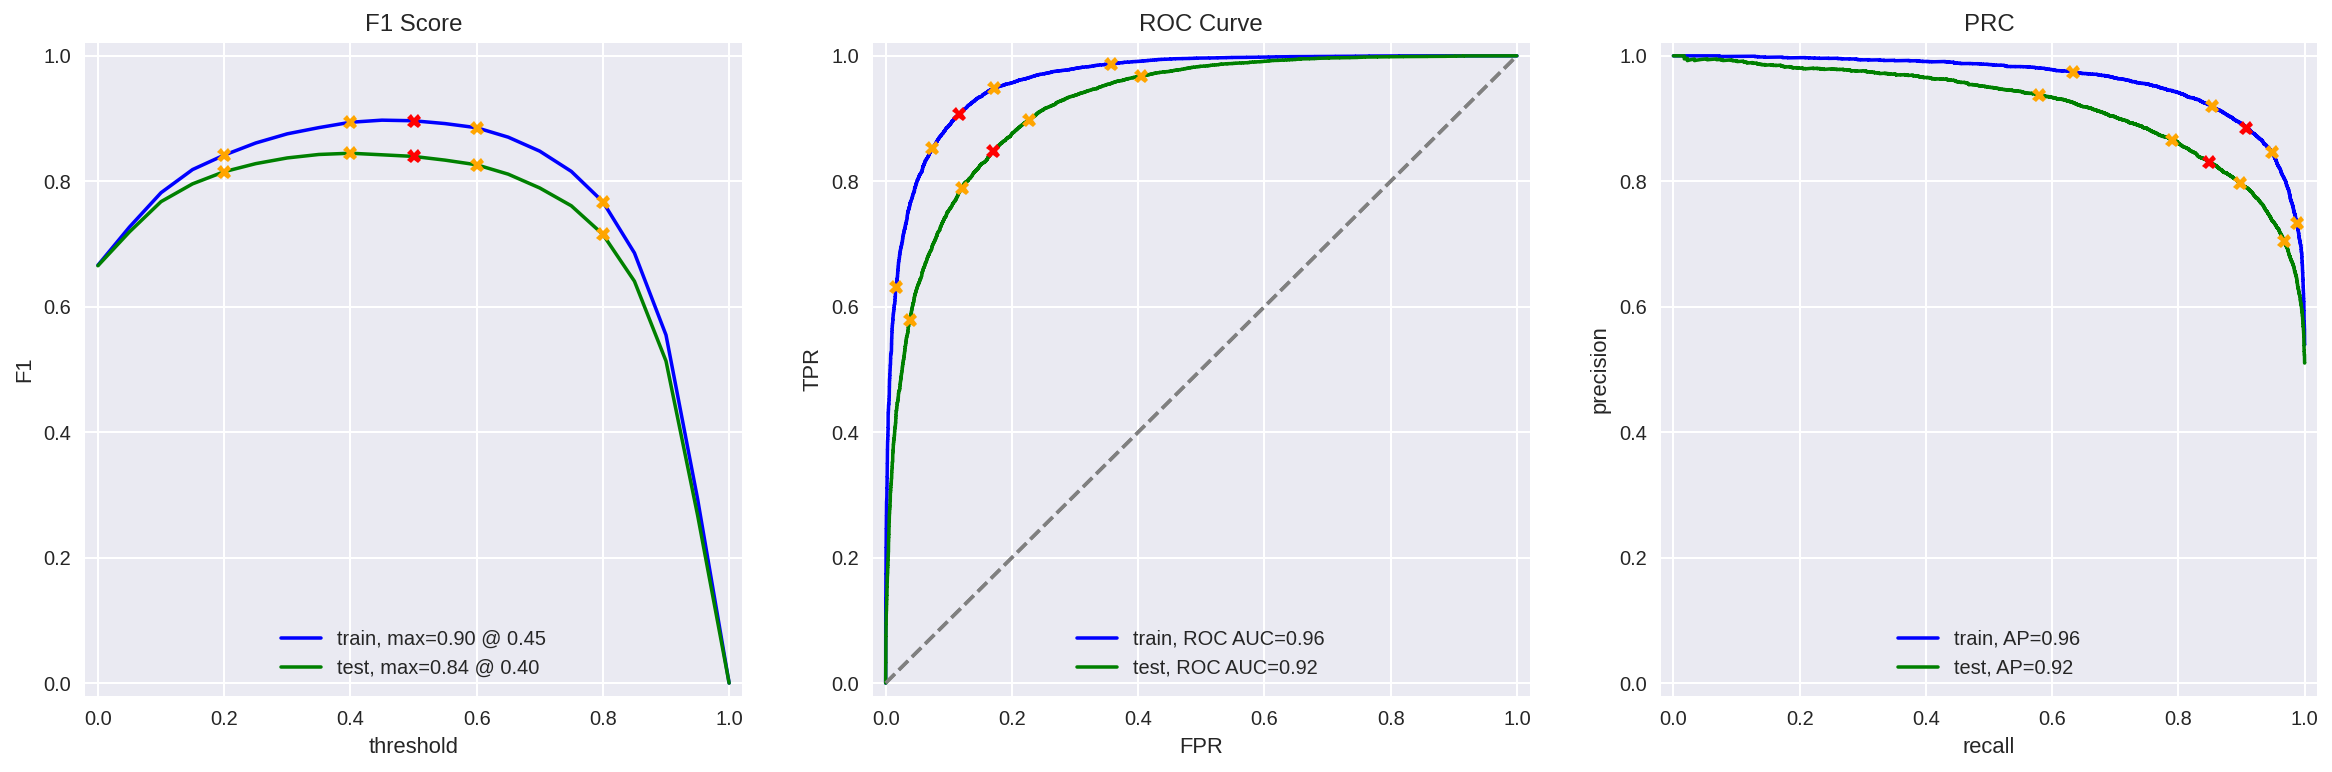

In [30]:
# Create and train an LGBMClassifier model
lgbm_model = LGBMClassifier(random_state=12345, n_jobs=-1)
lgbm_model.fit(train_X_tfidf, train_target)

# Evaluate the model
evaluate_model(lgbm_model, train_X_tfidf, train_target, test_X_tfidf, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you successfully vectorized text data using TF-IDF and trained a couple of different models using the resulting features

</div>

## My Reviews

In [32]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)


my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [41]:
texts = my_reviews['review_norm']
texts_transformed = vectorizer.transform(texts)
my_reviews_pred_prob = model_1.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [43]:
texts = my_reviews['review_norm']

texts_transformed_3 = tfidf_vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x)))
my_reviews_pred_prob_3 = lr_model.predict_proba(texts_transformed_3)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.22:  i did not simply like it not my kind of movie
0.34:  well i was bored and felt asleep in the middle of the movie
0.44:  i was really fascinated with the movie
0.06:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.17:  i didnt expect the reboot to be so good writers really cared about the source material
0.39:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [44]:
texts_transformed_4 = tfidf_vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x)))
my_reviews_pred_prob_4 = lgbm_model.predict_proba(texts_transformed_4)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_4[i]:.2f}:  {review}')

0.47:  i did not simply like it not my kind of movie
0.63:  well i was bored and felt asleep in the middle of the movie
0.63:  i was really fascinated with the movie
0.35:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.50:  i didnt expect the reboot to be so good writers really cared about the source material
0.60:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.20:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.86:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


<div class="alert alert-success">
<b>Reviewer's comment</b>

The models were applied to new data correctly

</div>

## Conclusions

<div style="background-color:#ADD8E6; padding: 20px; border-radius: 5px;">

## Model Evaluation Results

### Dummy Classifier
- **What it does:** This model always predicts the most frequent class in the dataset.
- **Performance Metrics:**
    - **Train & Test Accuracy:** 0.5
    - **F1 Score:** 0.0
    - **APS:** 0.5
    - **ROC AUC:** 0.5
- **Remarks:** As expected, the dummy classifier does not perform well. It provides a baseline comparison for other models.

### Logistic Regression (TF-IDF Vectorization)
- **What it does:** Uses TF-IDF to convert text reviews into vectors, then applies Logistic Regression for classification.
- **Performance Metrics:**
    - **Train Accuracy:** 0.94
    - **Test Accuracy:** 0.88
    - **F1 Score (Test):** 0.88
    - **APS (Test):** 0.95
    - **ROC AUC (Test):** 0.95
- **Remarks:** This model outperforms the dummy classifier significantly, effectively identifying both positive and negative reviews.

### Logistic Regression (TF-IDF Vectorization with spaCy Preprocessing)
- **What it does:** First, lemmatizes text and removes stop words using spaCy, then vectorizes with TF-IDF and applies Logistic Regression.
- **Performance Metrics:**
    - **Train Accuracy:** 0.87
    - **Test Accuracy:** 0.86
    - **F1 Score (Test):** 0.86
    - **APS (Test):** 0.93
    - **ROC AUC (Test):** 0.93
- **Remarks:** This model's performance is slightly lower than the simple TF-IDF with Logistic Regression, possibly due to removing certain terms or limitations from max_features.

### LGBM Classifier (TF-IDF Vectorization with spaCy Preprocessing)
- **What it does:** Uses the same preprocessing as the previous model but employs Light Gradient Boosting Model for classification.
- **Performance Metrics:**
    - **Train Accuracy:** 0.90
    - **Test Accuracy:** 0.84
    - **F1 Score (Test):** 0.84
    - **APS (Test):** 0.92
    - **ROC AUC (Test):** 0.92
- **Remarks:** This model seems to overfit slightly, having higher training accuracy compared to test accuracy. It also performs slightly worse than the Logistic Regression model with spaCy preprocessing in terms of the F1 score.

<p style="font-style:italic;">From these evaluations, it's evident that the simple TF-IDF with Logistic Regression model achieves the best results, though improvements can potentially be explored further.</p>

</div>


<div style="background-color:#ADD8E6; padding: 20px; border-radius: 5px;">

## Observations on Custom Reviews Classification

### TF-IDF with Logistic Regression (model_1)
- **Performance Observations:** This model appears to give promising results overall.
    - For the review "i was really fascinated with the movie", the model treads a cautious line, yielding a score of 0.56. The absence of overtly positive sentiment terms might be the reason for this borderline classification.

### TF-IDF with spaCy preprocessing and Logistic Regression
- **Performance Observations:** The model displays extreme confidence in its predictions, showcasing scores either close to 0 or 1 for the majority of reviews.
    - However, it errs in the case of the review "i didnt expect the reboot to be so good writers really cared about the source material", marking it with a surprisingly low score of 0.17. This misclassification could be explored further to understand the underlying factors.

### LGBM Classifier
- **Performance Observations:** This model exhibits mixed outcomes, with certain reviews causing uncertainty.
    - For reviews such as "i did not simply like it not my kind of movie" and "i didnt expect the reboot to be so good writers really cared about the source material", the model provides scores around the 0.5 mark. This showcases ambiguity in its decision-making for these reviews.

<p style="font-style:italic;">The observations suggest that while certain models can confidently classify a majority of reviews, certain phrases or constructions might lead to uncertainty or misclassification. A deeper dive into these anomalies could provide insights for further optimization of the models.</p>

</div>


<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice summary of the results! Conclusions make sense

</div>